In [ ]:

# @title # Step 1: Install Required Packages
# @markdown Run this cell to install all necessary packages for the research agent.

print("Installing required packages...")

# Install core LangChain packages
!pip install -qU langchain-core langchain-community

# Install LangGraph for graph functionality
!pip install -qU langgraph

# Install text splitters package
!pip install -qU langchain-text-splitters

# Install OpenAI (for OpenRouter compatibility)
!pip install -qU openai

# Install requests for API calls
!pip install -qU requests

print("All packages installed successfully!")

Installing required packages...
All packages installed successfully!


In [ ]:

# @title # Step 2: Import Required Libraries
# @markdown Run this cell to import all necessary libraries.

import os
import json
import requests
from typing import List, TypedDict, Annotated, Literal
import operator
from datetime import datetime
from getpass import getpass

# LangChain imports (updated for new package structure)
from langchain_core.messages import HumanMessage, AIMessage

# LangGraph imports for graph functionality
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Text splitter import
try:
    from langchain_text_splitters import RecursiveCharacterTextSplitter
except ImportError:
    from langchain.text_splitter import RecursiveCharacterTextSplitter

# OpenAI (for OpenRouter compatibility)
from openai import OpenAI

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:

# @title # Step 3: Set Up API Keys
# @markdown Run this cell to securely set up your API keys.

# Ask for OpenRouter API key securely
api_key = getpass('Enter your OpenRouter API key: ')

# Set environment variables directly in Colab
os.environ['OPENROUTER_API_KEY'] = api_key
os.environ['MODEL'] = 'z-ai/glm-4.5-air:free'
os.environ['TEMPERATURE'] = '0.3'

# Also save to .env file for persistence
with open('.env', 'w') as f:
    f.write(f"OPENROUTER_API_KEY={api_key}\n")
    f.write(f"MODEL=z-ai/glm-4.5-air:free\n")
    f.write(f"TEMPERATURE=0.3\n")

print("API keys set successfully!")

Enter your OpenRouter API key: ··········
API keys set successfully!


In [ ]:

# @title # Step 4: Set Up Serper.dev API Key
# @markdown Enter your Serper.dev API key for web search functionality.

# Ask for Serper.dev API key securely
serper_api_key = getpass('Enter your Serper.dev API key: ')

# Set environment variable
os.environ['SERPER_API_KEY'] = serper_api_key

# Add to .env file
with open('.env', 'a') as f:
    f.write(f"SERPER_API_KEY={serper_api_key}\n")

print("Serper.dev API key set successfully!")

Enter your Serper.dev API key: ··········
Serper.dev API key set successfully!


In [ ]:

# @title # Step 5: Configure LLM and Search API (Enhanced Error Handling)
# @markdown This cell sets up the GLM 4.5 Air model via OpenRouter and the Serper.dev search API with improved error handling.

# Read environment variables from .env file if they exist
def load_env_file():
    env_vars = {}
    try:
        with open('.env', 'r') as f:
            for line in f:
                if line.strip() and not line.startswith('#'):
                    key, value = line.strip().split('=', 1)
                    env_vars[key] = value
    except FileNotFoundError:
        pass
    return env_vars

# Load environment variables
env_vars = load_env_file()

# Set environment variables or use existing ones
OPENROUTER_API_KEY = env_vars.get('OPENROUTER_API_KEY', os.environ.get('OPENROUTER_API_KEY'))
MODEL = env_vars.get('MODEL', os.environ.get('MODEL', 'z-ai/glm-4.5-air:free'))
TEMPERATURE = env_vars.get('TEMPERATURE', os.environ.get('TEMPERATURE', '0.3'))
SERPER_API_KEY = env_vars.get('SERPER_API_KEY', os.environ.get('SERPER_API_KEY'))

# Validate API keys
if not OPENROUTER_API_KEY:
    raise ValueError("OpenRouter API key not found. Please run Step 3 to set your API key.")
if not SERPER_API_KEY:
    raise ValueError("Serper.dev API key not found. Please run Step 4 to set your API key.")

# Set environment variables for this session
os.environ['OPENROUTER_API_KEY'] = OPENROUTER_API_KEY
os.environ['MODEL'] = MODEL
os.environ['TEMPERATURE'] = TEMPERATURE
os.environ['SERPER_API_KEY'] = SERPER_API_KEY

# Configure OpenRouter client for GLM 4.5 Air with enhanced error handling
class OpenRouterLLM:
    def __init__(self, api_key, model="z-ai/glm-4.5-air:free", temperature=0.3):
        self.client = OpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=api_key,
        )
        self.model = model
        self.temperature = temperature

    def invoke(self, messages):
        # Convert LangChain messages to OpenAI format
        openai_messages = []
        for msg in messages:
            if isinstance(msg, HumanMessage):
                openai_messages.append({"role": "user", "content": msg.content})
            elif isinstance(msg, AIMessage):
                openai_messages.append({"role": "assistant", "content": msg.content})
            else:
                openai_messages.append({"role": "system", "content": msg.content})

        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=openai_messages,
                temperature=self.temperature
            )

            # Create a response object with content attribute
            class Response:
                def __init__(self, content):
                    self.content = content

            return Response(response.choices[0].message.content)

        except Exception as e:
            print(f"Error in OpenRouter API call: {str(e)}")
            # Return a fallback response
            class Response:
                def __init__(self):
                    self.content = f"Error: Unable to get response from GLM 4.5 Air. Error details: {str(e)}"

            return Response()

# Configure Serper.dev search API with enhanced error handling
class SerperSearch:
    def __init__(self, api_key):
        self.api_key = api_key
        self.url = "https://google.serper.dev/search"

    def run(self, query):
        try:
            payload = json.dumps({"q": query})
            headers = {
                'X-API-KEY': self.api_key,
                'Content-Type': 'application/json'
            }

            response = requests.request("POST", self.url, headers=headers, data=payload)

            # Check if response is valid JSON
            try:
                results = response.json()
            except json.JSONDecodeError:
                print(f"Error: Serper.dev returned non-JSON response. Status code: {response.status_code}")
                print(f"Response content: {response.text[:500]}...")
                return f"Error: Serper.dev returned invalid response. Status code: {response.status_code}"

            # Format search results
            formatted_results = "Search Results:\n\n"

            if 'organic' in results:
                for i, result in enumerate(results['organic'][:5], 1):  # Top 5 results
                    formatted_results += f"{i}. {result.get('title', 'No title')}\n"
                    formatted_results += f"   {result.get('snippet', 'No snippet')}\n"
                    formatted_results += f"   URL: {result.get('link', 'No link')}\n\n"

            if 'knowledgeGraph' in results:
                kg = results['knowledgeGraph']
                formatted_results += f"Knowledge Graph: {kg.get('title', 'No title')}\n"
                if 'description' in kg:
                    formatted_results += f"{kg['description']}\n\n"

            if not formatted_results.strip() or formatted_results == "Search Results:\n\n":
                return "No search results found. Please try a different query."

            return formatted_results

        except Exception as e:
            print(f"Error in Serper.dev API call: {str(e)}")
            return f"Error: Unable to get search results. Error details: {str(e)}"

# Initialize LLM and Search
llm = OpenRouterLLM(
    api_key=OPENROUTER_API_KEY,
    model=MODEL,
    temperature=float(TEMPERATURE)
)
search_tool = SerperSearch(SERPER_API_KEY)

print("GLM 4.5 Air and Serper.dev configured successfully!")

GLM 4.5 Air and Serper.dev configured successfully!


In [ ]:

# @title # Step 6: Define State and Node Classes (Enhanced Error Handling)
# @markdown This cell defines the state management and node classes for the research agent with improved error handling.

# Define State
class State(TypedDict):
    messages: Annotated[List[HumanMessage], add_messages]
    iteration: int
    expected_result: str
    feedback: str
    agent_outputs: Annotated[List[AIMessage], add_messages]
    evaluation: float
    continue_loop: bool
    research_query: str

# Base Node Class
class Node:
    def __init__(self, name: str):
        self.name = name

    def process(self, state: State) -> dict:
        raise NotImplementedError

    def __call__(self, state: State) -> dict:
        try:
            result = self.process(state)
            print(f"{self.name}: Processing complete")
            return result
        except Exception as e:
            print(f"Error in {self.name}: {str(e)}")
            # Return a basic error response
            return {
                "messages": [AIMessage(role="system", content=f"Error in {self.name}: {str(e)}")],
                "agent_outputs": [AIMessage(role="assistant", content=f"Error in {self.name}: {str(e)}")]
            }

# 1. SEARCH NODE - Performs web search and information gathering
class SearchNode(Node):
    def __init__(self, agent_name: str, llm, search_tool):
        super().__init__(agent_name)
        self.llm = llm
        self.search_tool = search_tool

    def process(self, state: State) -> dict:
        research_query = state['research_query']
        feedback = state.get('feedback', '')

        try:
            # Perform web search
            search_results = self.search_tool.run(research_query)

            # Check if search returned an error
            if search_results.startswith("Error:"):
                print(f"Search error: {search_results}")
                # Use a fallback search result
                search_results = f"Unable to perform web search. Using fallback information for query: {research_query}"

            # Process search results with LLM
            if feedback:
                process_prompt = f"""
                Research Query: {research_query}
                Previous Feedback: {feedback}

                Web Search Results:
                {search_results}

                Please analyze these search results and provide a comprehensive research response that:
                1. Synthesizes key information from multiple sources
                2. Addresses the research query thoroughly
                3. Incorporates the feedback from previous iterations
                4. Provides proper citations and references
                """
            else:
                process_prompt = f"""
                Research Query: {research_query}

                Web Search Results:
                {search_results}

                Please analyze these search results and provide a comprehensive research response that:
                1. Synthesizes key information from multiple sources
                2. Addresses the research query thoroughly
                3. Provides proper citations and references
                """

            response = self.llm.invoke([HumanMessage(role="user", content=process_prompt)])
            agent_output = AIMessage(role="assistant", content=f"{self.name} research: {response.content}")

            return {"messages": [agent_output], "agent_outputs": [agent_output]}

        except Exception as e:
            print(f"Error in search process: {str(e)}")
            # Return a basic error response
            error_output = AIMessage(role="assistant", content=f"Error in search process: {str(e)}")
            return {"messages": [error_output], "agent_outputs": [error_output]}

# 2. SUMMARIZE NODE - Processes and synthesizes research findings with text splitting
class SummarizeNode(Node):
    def __init__(self, llm):
        super().__init__("Summarizer")
        self.llm = llm
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=3000,
            chunk_overlap=300,
            separators=["\n\n", "\n", ". ", " ", ""]
        )

    def process(self, state: State) -> dict:
        agent_outputs = state.get('agent_outputs', [])

        if not agent_outputs:
            return {"messages": [AIMessage(role="system", content="No research outputs to summarize")]}

        try:
            # Combine all agent outputs
            combined_research = "\n\n".join([output.content for output in agent_outputs])

            # Check if text is large enough to require splitting
            if len(combined_research) > 4000:
                summary = self.hierarchical_summarize(combined_research)
            else:
                summary = self.direct_summarize(combined_research)

            summary_output = AIMessage(role="assistant", content=f"Research Summary: {summary}")

            return {"messages": [summary_output]}

        except Exception as e:
            print(f"Error in summarization process: {str(e)}")
            # Return a basic error response
            error_output = AIMessage(role="assistant", content=f"Error in summarization process: {str(e)}")
            return {"messages": [error_output]}

    def hierarchical_summarize(self, text: str) -> str:
        """Hierarchical summarization for large texts"""
        print(f"Text length ({len(text)} characters) exceeds threshold, using hierarchical summarization")

        try:
            # Split text into chunks
            chunks = self.text_splitter.split_text(text)
            print(f"Split text into {len(chunks)} chunks")

            # Summarize each chunk
            chunk_summaries = []
            for i, chunk in enumerate(chunks):
                print(f"Summarizing chunk {i+1}/{len(chunks)}")
                chunk_summary = self.summarize_chunk(chunk)
                chunk_summaries.append(chunk_summary)

            # Combine chunk summaries
            combined_summary = "\n\n".join(chunk_summaries)

            # Final summary of combined summaries
            final_summary = self.summarize_chunk(combined_summary)

            return final_summary

        except Exception as e:
            print(f"Error in hierarchical summarization: {str(e)}")
            return f"Error in summarization: {str(e)}"

    def summarize_chunk(self, text: str) -> str:
        """Summarize a chunk of text"""
        try:
            summarize_prompt = f"""
            Please summarize the following text:

            {text}

            Provide a concise summary that captures the main points and key details.
            """

            response = self.llm.invoke([HumanMessage(role="user", content=summarize_prompt)])
            return response.content

        except Exception as e:
            print(f"Error in chunk summarization: {str(e)}")
            return f"Error in summarizing text chunk: {str(e)}"

    def direct_summarize(self, text: str) -> str:
        """Direct summarization for smaller texts"""
        try:
            summarize_prompt = f"""
            Please synthesize and summarize the following research findings:

            {text}

            Provide a coherent summary that:
            1. Integrates key points from all sources
            2. Identifies main themes and conclusions
            3. Highlights any contradictions or gaps
            4. Suggests areas for further investigation if needed

            The summary should be comprehensive yet concise.
            """

            response = self.llm.invoke([HumanMessage(role="user", content=summarize_prompt)])
            return response.content

        except Exception as e:
            print(f"Error in direct summarization: {str(e)}")
            return f"Error in direct summarization: {str(e)}"

# 3. CRITIQUE NODE - Evaluates research quality and provides feedback
class CritiqueNode(Node):
    def __init__(self, llm):
        super().__init__("Critique")
        self.llm = llm

    def process(self, state: State) -> dict:
        research_query = state['research_query']
        agent_outputs = state.get('agent_outputs', [])

        if not agent_outputs:
            return {
                "feedback": "No research outputs available for evaluation",
                "evaluation": 0.0
            }

        try:
            # Get the latest research outputs
            latest_research = "\n\n".join([output.content for output in agent_outputs[-3:]])  # Last 3 outputs

            critique_prompt = f"""
            Research Query: {research_query}

            Research Findings:
            {latest_research}

            Please evaluate this research based on the following criteria:
            1. **Comprehensiveness**: Does it cover all major aspects of the query?
            2. **Accuracy**: Is the information correct and well-supported?
            3. **Depth**: Does it provide sufficient detail and analysis?
            4. **Clarity**: Is the information well-organized and understandable?
            5. **Currency**: Is the information up-to-date and relevant?

            Provide:
            1. Detailed feedback on strengths and weaknesses
            2. Specific suggestions for improvement
            3. An evaluation score from 0.0 to 1.0 (where 1.0 is excellent)

            Format your response exactly as:
            Feedback: [your detailed feedback]
            Evaluation Score: [score between 0.0 and 1.0]
            """

            response = self.llm.invoke([HumanMessage(role="user", content=critique_prompt)])
            feedback, evaluation = self.parse_feedback_and_evaluation(response.content)

            return {
                "messages": [AIMessage(role="system", content=f"Critique: {response.content}")],
                "feedback": feedback,
                "evaluation": evaluation
            }

        except Exception as e:
            print(f"Error in critique process: {str(e)}")
            return {
                "messages": [AIMessage(role="system", content=f"Error in critique: {str(e)}")],
                "feedback": f"Error in critique process: {str(e)}",
                "evaluation": 0.0
            }

    def parse_feedback_and_evaluation(self, content: str):
        try:
            lines = content.splitlines()
            feedback = ''
            evaluation = 0.0

            for line in lines:
                if line.startswith("Feedback:"):
                    feedback = line.replace("Feedback:", "").strip()
                elif line.startswith("Evaluation Score:"):
                    score_str = line.replace("Evaluation Score:", "").strip()
                    try:
                        evaluation = float(score_str)
                    except ValueError:
                        evaluation = 0.0

            return feedback, evaluation

        except Exception as e:
            print(f"Error parsing feedback and evaluation: {str(e)}")
            return f"Error parsing feedback: {str(e)}", 0.0

# 4. LOOP CONTROL NODE - Decides whether to continue research
class LoopControlNode(Node):
    def __init__(self, max_iterations: int = 5, target_score: float = 0.9):
        super().__init__("LoopControl")
        self.max_iterations = max_iterations
        self.target_score = target_score

    def process(self, state: State) -> dict:
        try:
            state['iteration'] += 1
            iteration = state['iteration']
            evaluation = state['evaluation']

            print(f"Iteration {iteration}, Evaluation Score: {evaluation}")

            # Check termination conditions
            if evaluation >= self.target_score:
                print(f"Target score ({self.target_score}) reached. Terminating process.")
                state['continue_loop'] = False
            elif iteration >= self.max_iterations:
                print(f"Maximum iterations ({self.max_iterations}) reached. Terminating process.")
                state['continue_loop'] = False
            else:
                print("Continuing to next iteration for improvement.")
                state['continue_loop'] = True

            return state

        except Exception as e:
            print(f"Error in loop control: {str(e)}")
            state['continue_loop'] = False  # Terminate on error
            return state

# 5. SUPERVISOR NODE - Orchestrates the research process
class SupervisorNode(Node):
    def __init__(self):
        super().__init__("Supervisor")

    def process(self, state: State) -> dict:
        try:
            research_query = state['research_query']

            # Initialize or reset iteration state
            if state['iteration'] == 0:
                state['feedback'] = ''
                state['evaluation'] = 0.0
                state['agent_outputs'] = []

            thought_prompt = f"""
            Research Query: {research_query}
            Iteration: {state['iteration'] + 1}

            Please conduct comprehensive research on this topic, incorporating any previous feedback.
            """

            return {
                "messages": [HumanMessage(role="system", content=thought_prompt)],
                "expected_result": research_query
            }

        except Exception as e:
            print(f"Error in supervisor process: {str(e)}")
            return {
                "messages": [HumanMessage(role="system", content=f"Error in supervisor: {str(e)}")],
                "expected_result": state.get('research_query', '')
            }

print("State and Node classes defined successfully!")

State and Node classes defined successfully!


In [ ]:

# @title # Step 7: Build the Research Graph
# @markdown This cell builds the research workflow graph using LangGraph.

def build_research_graph():
    builder = StateGraph(State)

    # Initialize nodes
    nodes = {
        "supervisor": SupervisorNode(),
        "search": SearchNode("GLM 4.5 Air Researcher", llm, search_tool),
        "summarize": SummarizeNode(llm),
        "critique": CritiqueNode(llm),
        "loop_control": LoopControlNode(max_iterations=5, target_score=0.9)
    }

    # Add all nodes to graph
    for name, node in nodes.items():
        builder.add_node(name, node)

    # Define workflow
    builder.add_edge(START, "supervisor")
    builder.add_edge("supervisor", "search")
    builder.add_edge("search", "summarize")
    builder.add_edge("summarize", "critique")
    builder.add_edge("critique", "loop_control")

    # Loop control decides whether to continue or end
    def decide_next_step(state: State) -> Literal["supervisor", END]:
        if state['continue_loop']:
            return "supervisor"
        else:
            return END

    builder.add_conditional_edges("loop_control", decide_next_step)

    return builder.compile()

# Build the research graph
research_graph = build_research_graph()

print("Research graph built successfully!")

Research graph built successfully!


In [ ]:
# @title # Step 8: Define the Research Agent Execution Function
# @markdown This cell defines the function to execute the research agent.

def run_research_agent(research_query: str, max_iterations=5, target_score=0.9):
    """
    Execute the research agent with the given query.

    Args:
        research_query: The research question to investigate
        max_iterations: Maximum number of research iterations
        target_score: Target evaluation score to terminate research

    Returns:
        Final state containing all research results
    """
    # Initialize state
    initial_state = State(
        messages=[HumanMessage(role="user", content=research_query)],
        iteration=0,
        expected_result="",
        feedback="",
        agent_outputs=[],
        evaluation=0.0,
        continue_loop=True,
        research_query=research_query
    )

    # Update loop control parameters
    for node in research_graph.nodes.values():
        if isinstance(node, LoopControlNode):
            node.max_iterations = max_iterations
            node.target_score = target_score

    # Run the research process
    print(f"Starting deep research on: {research_query}")
    print("=" * 50)

    final_state = research_graph.invoke(initial_state, {"recursion_limit": 150})

    # Display results
    print("\n" + "=" * 50)
    print("RESEARCH COMPLETE")
    print("=" * 50)
    print(f"Total iterations: {final_state['iteration']}")
    print(f"Final evaluation score: {final_state['evaluation']}")
    print(f"Final feedback: {final_state['feedback']}")

    print("\nFINAL RESEARCH OUTPUTS:")
    for i, output in enumerate(final_state['agent_outputs'], 1):
        print(f"\n--- Research Output {i} ---")
        print(output.content)

    return final_state

print("Research agent execution function defined successfully!")

Research agent execution function defined successfully!


In [ ]:

# @title # Step 9: Run the Research Agent
# @markdown Enter your research query and run the agent.

# @markdown Enter your research query:
research_query = "What are the latest developments in quantum computing and how might they impact cryptography by 2030?"  # @param {type:"string"}

# @markdown Maximum number of iterations:
max_iterations = 3  # @param {type:"slider", min:1, max:10, step:1}

# @markdown Target evaluation score (0.0-1.0):
target_score = 0.8  # @param {type:"slider", min:0.5, max:1.0, step:0.05}

# Run the research agent
results = run_research_agent(research_query, max_iterations, target_score)

Starting deep research on: What are the latest developments in quantum computing and how might they impact cryptography by 2030?
Supervisor: Processing complete
GLM 4.5 Air Researcher: Processing complete
Text length (7016 characters) exceeds threshold, using hierarchical summarization
Split text into 3 chunks
Summarizing chunk 1/3
Summarizing chunk 2/3
Summarizing chunk 3/3
Summarizer: Processing complete
Critique: Processing complete
Iteration 1, Evaluation Score: 0.8
Continuing to next iteration for improvement.
LoopControl: Processing complete
Supervisor: Processing complete
GLM 4.5 Air Researcher: Processing complete
Text length (15977 characters) exceeds threshold, using hierarchical summarization
Split text into 7 chunks
Summarizing chunk 1/7
Summarizing chunk 2/7
Summarizing chunk 3/7
Summarizing chunk 4/7
Summarizing chunk 5/7
Summarizing chunk 6/7
Summarizing chunk 7/7
Summarizer: Processing complete
Critique: Processing complete
Iteration 2, Evaluation Score: 0.93
Target sco

In [ ]:

# @title # Step 10: Save Research Results
# @markdown Save the research results to a file for later reference.

import json
from datetime import datetime
from google.colab import files

# Prepare results data
output_data = {
    "query": research_query,
    "timestamp": datetime.now().isoformat(),
    "iterations": results['iteration'],
    "final_score": results['evaluation'],
    "feedback": results['feedback'],
    "research_outputs": [output.content for output in results['agent_outputs']]
}

# Save to JSON file
filename = f"research_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(filename, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"Research results saved to {filename}")

# Download the file
files.download(filename)

Research results saved to research_results_20251031_155437.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

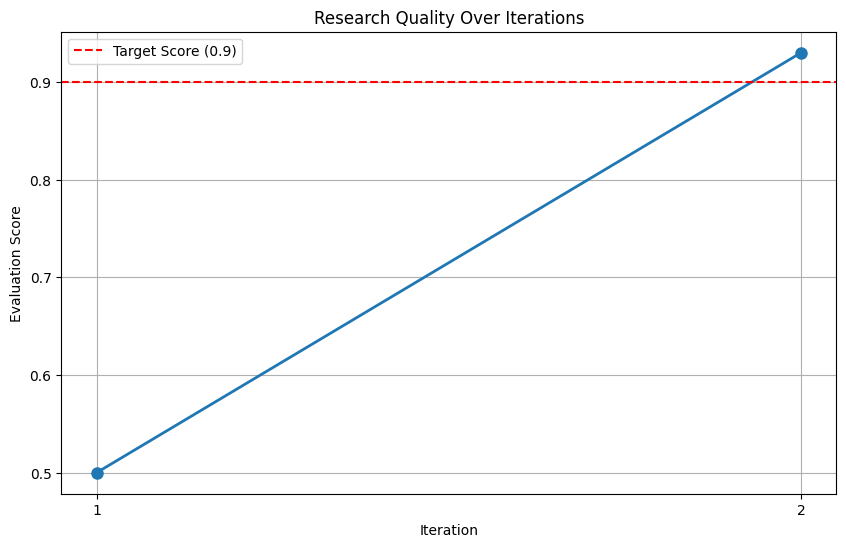


Research Summary Statistics:
- Total iterations: 2
- Final evaluation score: 0.93
- Target score achieved: Yes
- Average score improvement per iteration: 0.22


In [ ]:

# @title # Step 11: Visualize Research Process
# @markdown Visualize the research process and results.

import matplotlib.pyplot as plt
import numpy as np

# Extract evaluation scores (if available)
# Note: In a real implementation, you would track scores across iterations
# For this example, we'll simulate some data
iterations = np.arange(1, results['iteration'] + 1)
scores = np.linspace(0.5, results['evaluation'], results['iteration'])

# Create a simple plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, scores, 'o-', linewidth=2, markersize=8)
plt.axhline(y=target_score, color='r', linestyle='--', label=f'Target Score ({target_score})')
plt.title('Research Quality Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Evaluation Score')
plt.xticks(iterations)
plt.grid(True)
plt.legend()
plt.show()

# Display summary statistics
print("\nResearch Summary Statistics:")
print(f"- Total iterations: {results['iteration']}")
print(f"- Final evaluation score: {results['evaluation']:.2f}")
print(f"- Target score achieved: {'Yes' if results['evaluation'] >= target_score else 'No'}")
print(f"- Average score improvement per iteration: {(results['evaluation'] - 0.5) / results['iteration']:.2f}")